# Tile Model: #

In this class there can be found both the tile coding, as well as the state model to learn.

Tile coding is implemented straight forward:
The observation, in out case position and velocity, is first shifted to avoid negative coordinated, and later scaled to the grid size. 

If we expect a grid of 8*8, after scaling and shifting, the range of the input is between [0,8] in both dimensions.

For tiling the grids of each tiling level are shifted to its neighbour by 1/numberOfTilings. Before being copied into the coordinates grid (tiling\*gridsize\*gridsize)the observation is shifted accordingly and casted to an int.

Now we have a lot of discrete points in the space (tiling\*gridsize\*gridsize). In a second step this 3D address of a point is mapped to point to a 1D-array to store the states. Mapping is done straigthforward: 

Tiling 0: mapped to 0...63
Tiling 1: mapped to 64 ... 127 and so on.

Inside one tiling level it is simiiar:
(position,velocity) is mapped to position+8*velocity.

As result we get an index vector, containing the index for each tiling.

In [1]:
import gym
import os
import numpy as np
os.environ["DISPLAY"] = ":0"

nbEpisodes=1
nbTimesteps=50
env = gym.make('MountainCar-v0')

class tileModel:
    def __init__(self, nbTilings, gridSize):
        # characteristica of observation
        self.obsHigh = env.observation_space.high
        self.obsLow = env.observation_space.low
        self.obsDim = len(self.obsHigh)
        
        # characteristica of tile model
        self.nbTilings = nbTilings
        self.gridSize = gridSize
        self.gridWidth = np.divide(np.subtract(self.obsHigh,self.obsLow), self.gridSize)
        self.nbTiles = (self.gridSize**self.obsDim) * self.nbTilings
        self.nbTilesExtra = (self.gridSize**self.obsDim) * (self.nbTilings+1)
        
        #state space
        self.nbActions = env.action_space.n
        self.resetStates()
        
    def resetStates(self):
        self.states = np.random.uniform(low=0.0, high=0.0001, size=(self.nbTilesExtra,self.nbActions))
        ### self.states = np.zeros([self.nbTiles,self.nbActions])
        
        
    def displayM(self):
        print('observation:\thigh:', self.obsHigh, 'low:', self.obsLow, 'dim:',self.obsDim )
        print('tile model:\tnbTilings:', self.nbTilings, 'gridSize:',self.gridSize, 'gridWidth:',self.gridWidth,'nb tiles:', self.nbTiles )
        print('state space:\tnb of actions:', self.nbActions, 'size of state space:', self.nbTiles)
        
    def code (self, obsOrig):
        #shift the original observation to range [0, obsHigh-obsLow]
        #scale it to the external grid size: if grid is 8*8, each range is [0,8]
        obsScaled = np.divide(np.subtract(obsOrig,self.obsLow),self.gridWidth)
        ### print ('\noriginal obs:',obsOrig,'shifted and scaled obs:', obsScaled )
        
        #compute the coordinates/tiling
        #each tiling is shifted by tiling/gridSize, i.e. tiling*1/8 for grid 8*8
        #and casted to integer
        coordinates = np.zeros([self.nbTilings,self.obsDim])
        tileIndices = np.zeros(self.nbTilings)
        for tiling in range(self.nbTilings):
            coordinates[tiling,:] = obsScaled + tiling/ self.nbTilings
        coordinates=np.floor(coordinates)
        
        #this coordinates should be used to adress a 1-dimensional status array
        #for 8 tilings of 8*8 grid we use:
        #for tiling 0: 0-63, for tiling 1: 64-127,...
        coordinatesOrg=np.array(coordinates, copy=True)        
        ### print ('coordinates:', coordinates)
        
        for dim in range(1,self.obsDim):
            coordinates[:,dim] *= self.gridSize**dim
        ### print ('coordinates:', coordinates)
        condTrace=False
        for tiling in range(self.nbTilings):
            tileIndices[tiling] = (tiling * (self.gridSize**self.obsDim) \
                                   + sum(coordinates[tiling,:])) 
            if tileIndices[tiling] >= self.nbTilesExtra:
                condTrace=True
                
        if condTrace:
            print("code: obsOrig:",obsOrig, 'obsScaled:', obsScaled, "coordinates w/o shift:\n", coordinatesOrg )
            print ("coordinates multiplied with base:\n", coordinates, "\ntileIndices:", tileIndices)
        ### print ('tileIndices:', tileIndices)
        ### print ('coordinates-org:', coordinatesOrg)
        return coordinatesOrg, tileIndices
    
    def getQ(self,state):
        Q=np.zeros(self.nbActions)
        _,tileIndices=self.code(state)
        ### print ('getQ-in : state',state,'tileIndices:', tileIndices)

        for i in range(len(tileIndices)):
            index=int(tileIndices[i])
            Q=np.add(Q,self.states[index])
        ### print ('getQ-out : Q',Q)
        Q=np.divide(Q,self.nbTilings)
        return Q
    
    def updateQ(self, state, action, deltaQA):
        _,tileIndices=self.code(state)
        ### print ('updateQ-in : state',state,'tileIndices:', tileIndices,'action:', action, 'deltaQA:', deltaQA)

        for i in range(len(tileIndices)):
            index=int(tileIndices[i])
            self.states[index,action]+=deltaQA
            ### print ('updateQ: index:', index, 'states[index]:',self.states[index])
            
    def preparePlot(self):
        plotInput=np.zeros([self.gridSize*self.nbTilings, self.gridSize*self.nbTilings,self.nbActions])    #pos*velo*actions
        iTiling=0
        iDim1=0                 #velocity
        iDim0=0                 #position
        ### tileShift=1/self.nbTilings
        
        for i in range(self.nbTiles):
            ### print ('i:',i,'iTiling:',iTiling,'iDim0:',iDim0, 'iDim1:', iDim1 ,'state:', self.states[i])
            for jDim0 in range(iDim0*self.nbTilings-iTiling, (iDim0+1)*self.nbTilings-iTiling):
                for jDim1 in range(iDim1*self.nbTilings-iTiling, (iDim1+1)*self.nbTilings-iTiling):
                    ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state before:', plotInput[jDim0,jDim1] )
                    if jDim0>0 and jDim1 >0:
                        plotInput[jDim0,jDim1]+=self.states[i]
                        ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state after:', plotInput[jDim0,jDim1] )
            iDim0+=1
            if iDim0 >= self.gridSize:
                iDim1 +=1
                iDim0 =0
            if iDim1 >= self.gridSize:
                iTiling +=1
                iDim0=0
                iDim1=0
        return plotInput
        
        
            

    

[2017-05-30 14:22:56,815] Making new env: MountainCar-v0


# Playing around with tile coding
To get some "inituitive feeling" about the value add of the tile coding,  the car starts on the left hill, and chooses the action randomly. 

What we see in the figures showing the discretisation that having several levels of discretisation shifted between each other keeps a bit more information than just increasing the granularity of the discretisation.

Episode finished after 39 timesteps


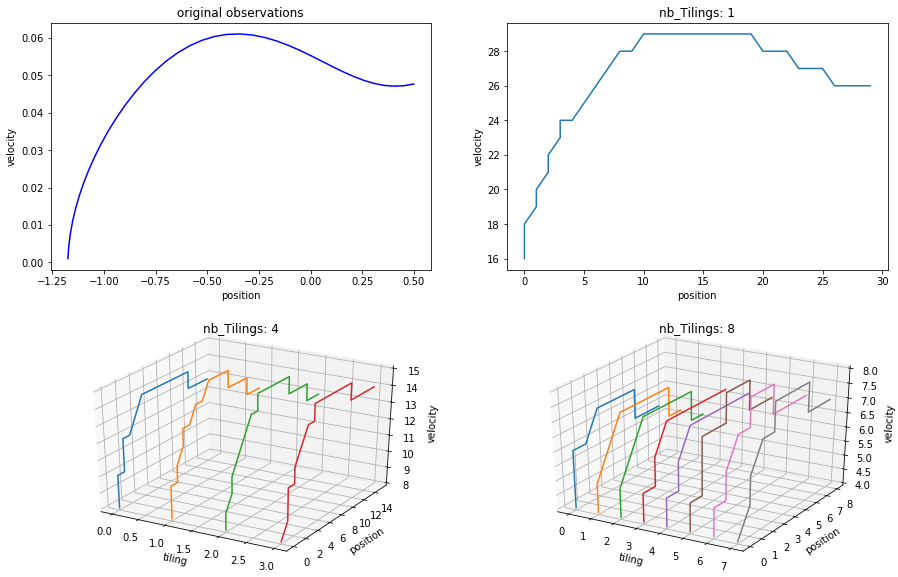

In [10]:
nbEpisodes =1
nbTimesteps = 200
tiles_1_32 = tileModel(1,32)                    #grid: 32*32, 1 tilings
tiles_4_16 = tileModel(4,16)                    #grid: 16*16, 4 tilings
tiles_8_8  = tileModel(8,8)                     #grid: 8*8, 8 tilings
###tiles.displayM()

for episode in range(nbEpisodes):                    
    position = []
    velocity = []
    tiling1=np.empty(shape=[nbTimesteps,2,1],dtype=int)
    tiling4=np.empty(shape=[nbTimesteps,2,4],dtype=int)
    tiling8=np.empty(shape=[nbTimesteps,2,8],dtype=int)
    finalRepetition=0

    obs = env.reset()
    #env.env.state =[-0.5, 0.0]
    env.env.state =[-1.174194984, 0.001]
    obs=env.env.state
    for t in range(nbTimesteps):
        i=1
        env.render()
        coord_1_32,tileIdx_1_32=tiles_1_32.code(obs)        
        coord_4_16,tileIdx_4_16=tiles_4_16.code(obs)
        coord_8_8,tileIdx_8_8=tiles_8_8.code(obs)
        
        #for plotting
        position.append(obs[0])
        velocity.append(obs[1])
        tiling1[t]=coord_1_32.T
        tiling4[t]=coord_4_16.T
        tiling8[t]=coord_8_8.T
        finalRepetition=t
        
        #action = env.action_space.sample()
        action = 2
        obs, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    
#plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
###import matplotlib as mpl
###print('tiling1',tiling1)
###print('tiling4',tiling4)
###print('tiling8',tiling8)
    
### plot it..
fig = plt.figure(figsize=(15,10))

#top left: original observations
ax1 = fig.add_subplot(221)
ax1.plot(position, velocity, 'b-')
ax1.set_xlabel('position')
ax1.set_ylabel('velocity')
ax1.set_title('original observations')

#top right: tiling=1
ax1 = fig.add_subplot(222)
ax1.plot(tiling1[:finalRepetition,0,0],tiling1[:finalRepetition,1,0])
ax1.set_xlabel('position')
ax1.set_ylabel('velocity')
ax1.set_title('nb_Tilings: 1')

#bottom left: tiling=4
ax1 = fig.add_subplot(223, projection='3d')
for i in range(4):
    ax1.plot([i]*finalRepetition,tiling4[:finalRepetition,0,i],tiling4[:finalRepetition,1,i])
ax1.set_xlabel('tiling')
ax1.set_ylabel('position')
ax1.set_zlabel('velocity')
ax1.set_title('nb_Tilings: 4')

#bottom right: tiling=8
ax1 = fig.add_subplot(224, projection='3d')
for i in range(8):
    ax1.plot([i]*finalRepetition,tiling8[:finalRepetition,0,i],tiling8[:finalRepetition,1,i])
ax1.set_xlabel('tiling')
ax1.set_ylabel('position')
ax1.set_zlabel('velocity')
ax1.set_title('nb_Tilings: 8')
plt.show()

    
